# Human Activity Recognition (HAR) from Smartphone Sensors using Transformer (UCI HAR)


**Проект:** Human Activity Recognition (HAR) from Smartphone Sensors using Transformer (UCI HAR)  
**Формат:** воспроизводимая научно-практическая работа в Colab  
**Задача:** сравнить табличный бейзлайн (Logistic Regression) и компактный Transformer на временных рядах  
**Целевая среда:** Google Colab Free (CPU/GPU)


## Аннотация

В данной работе решается задача классификации человеческой активности (Human Activity Recognition, HAR) по сигналам инерциальных датчиков смартфона. Используется датасет UCI HAR, содержащий временные окна сигналов акселерометра и гироскопа для 6 классов активности: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING.

Цель исследования — сравнить классический подход на инженерных признаках (Logistic Regression) и современную архитектуру Transformer, работающую с сырыми временными последовательностями длиной 128 отсчетов и 9 каналами признаков.

Эксперименты проводятся в воспроизводимой среде Google Colab с фиксированными seed и единым протоколом оценки (Accuracy, Macro Precision/Recall/F1, матрица ошибок). Дополнительно выполняется анализ ошибок для интерпретации слабых мест модели и выявления наиболее трудных пар классов.

Практическая ценность работы заключается в демонстрации того, как в условиях ограниченных вычислительных ресурсов (free Colab) построить корректный и научно оформленный пайплайн для задач временных рядов: от загрузки данных и EDA до сравнения моделей, анализа результатов и формулировки направлений улучшения.


## Введение

Автоматическое распознавание активности человека (HAR) является важной задачей на стыке машинного обучения, мобильных технологий и прикладной аналитики. HAR используется в фитнес-трекинге, мониторинге состояния здоровья, анализе поведения пользователей, реабилитации и системах контекстно-зависимых сервисов.

Классические подходы к HAR опираются на заранее вычисленные статистические признаки и методы машинного обучения (например, логистическая регрессия, SVM, случайный лес). Такие методы остаются сильным базовым ориентиром благодаря низкой вычислительной стоимости и интерпретируемости. Однако в последние годы последовательностные нейросетевые архитектуры (RNN, CNN1D, Transformer) позволяют извлекать более сложные зависимости напрямую из сырых сигналов.

В данной работе проверяется гипотеза:  
**компактный Transformer на сырых временных окнах способен достичь конкурентного качества по сравнению с классическим baseline на инженерных признаках, оставаясь вычислительно доступным в бесплатном Google Colab.**

Основные исследовательские вопросы:
1. Насколько Transformer улучшает (или не ухудшает) Macro-F1 относительно baseline?
2. Какие классы активности являются наиболее трудными для модели?
3. Какие ограничения влияют на итоговое качество в условиях ограниченного бюджета вычислений?


## Связанные работы

В задачах HAR традиционно применялись методы на признаках во временной и частотной областях с последующей классификацией (Logistic Regression, SVM, Random Forest). На датасетах умеренного размера такие методы часто дают стабильный результат и служат сильной отправной точкой.

С развитием deep learning появились подходы на основе 1D-CNN и RNN/LSTM, которые учатся выделять информативные паттерны из сырых временных сигналов. Transformer-подходы расширили этот класс методов благодаря self-attention, позволяющему моделировать глобальные зависимости внутри окна наблюдений.

Для небольших HAR-датасетов важен баланс между емкостью модели и риском переобучения: слишком крупные модели дают нестабильный выигрыш. Поэтому в настоящей работе используется **компактный TransformerEncoder**, что делает сравнение с классическим baseline честным и практически применимым.


## Описание датасета

Используется UCI HAR Dataset: записи инерциальных датчиков смартфона, собранные у 30 испытуемых при выполнении 6 типов активности:
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING

Данные представлены в двух формах:

1. **Инженерные признаки (tabular):**
   - `X_train.txt`, `X_test.txt`
   - 561 признак на объект
   - используются для baseline-модели (Logistic Regression)

2. **Сырые последовательности (inertial signals):**
   - окна длиной 128 отсчетов
   - 9 каналов сигналов
   - используются для Transformer-модели

Целевая переменная — метка активности (6 классов).  
Оценка проводится на test-части датасета, предоставленной авторами набора.


## Установка, импорты и версии библиотек

In [1]:
import os
import sys
import time
import math
import copy
import json
import random
import zipfile
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    f1_score,
)
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import display, Markdown

sns.set_theme(style="whitegrid")

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("PyTorch:", torch.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)


Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
PyTorch: 2.9.0+cu128
scikit-learn: 1.6.1
Matplotlib: 3.10.0
Seaborn: 0.13.2


## Настройка воспроизводимости

In [2]:
SEED = 42
BATCH_SIZE = 128
EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-4
D_MODEL = 64
NHEAD = 4
NUM_LAYERS = 2
DIM_FF = 128
DROPOUT = 0.1
PATIENCE = 5
LABEL_SMOOTHING = 0.05


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", DEVICE)
print("Фиксированный seed:", SEED)


Устройство: cuda
Фиксированный seed: 42


## Загрузка/распаковка/проверка датасета

In [3]:
DATA_ROOT = Path("/content")
ZIP_PATH = DATA_ROOT / "UCI_HAR_Dataset.zip"
DATA_DIR = DATA_ROOT / "UCI HAR Dataset"

UCI_HAR_URLS = [
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
    "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip",
    "https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/raw/master/data/UCI%20HAR%20Dataset.zip",
]


def download_file(url: str, dst: Path):
    urllib.request.urlretrieve(url, dst)


if not DATA_DIR.exists():
    success = False
    for url in UCI_HAR_URLS:
        try:
            print(f"Пробую скачать из: {url}")
            download_file(url, ZIP_PATH)
            success = True
            print("Скачивание успешно.")
            break
        except Exception as e:
            print(f"Ошибка: {e}")

    if not success:
        raise RuntimeError("Не удалось скачать UCI HAR из указанных источников.")

    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(DATA_ROOT)

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Ожидаемая папка датасета не найдена: {DATA_DIR}")

required_files = [
    DATA_DIR / "train" / "X_train.txt",
    DATA_DIR / "train" / "y_train.txt",
    DATA_DIR / "test" / "X_test.txt",
    DATA_DIR / "test" / "y_test.txt",
    DATA_DIR / "train" / "Inertial Signals" / "body_acc_x_train.txt",
    DATA_DIR / "test" / "Inertial Signals" / "body_acc_x_test.txt",
]

for fp in required_files:
    if not fp.exists():
        raise FileNotFoundError(f"Отсутствует ожидаемый файл: {fp}")

print("Папка датасета:", DATA_DIR)
print("Обязательные файлы: OK")

print("\nDirectory structure preview:")
for root, dirs, files in os.walk(DATA_DIR):
    rel = Path(root).relative_to(DATA_DIR)
    depth = len(rel.parts)
    if depth <= 2:
        indent = "  " * depth
        print(f"{indent}{rel if str(rel) != '.' else 'UCI HAR Dataset'}")
        for f in sorted(files)[:4]:
            print(f"{indent}  - {f}")


Пробую скачать из: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Скачивание успешно.
Папка датасета: /content/UCI HAR Dataset
Обязательные файлы: OK

Directory structure preview:
UCI HAR Dataset
  - .DS_Store
  - README.txt
  - activity_labels.txt
  - features.txt
  train
    - X_train.txt
    - subject_train.txt
    - y_train.txt
    train/Inertial Signals
      - body_acc_x_train.txt
      - body_acc_y_train.txt
      - body_acc_z_train.txt
      - body_gyro_x_train.txt
  test
    - X_test.txt
    - subject_test.txt
    - y_test.txt
    test/Inertial Signals
      - body_acc_x_test.txt
      - body_acc_y_test.txt
      - body_acc_z_test.txt
      - body_gyro_x_test.txt


## Функции парсинга данных

In [4]:
CLASS_NAMES = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING",
]

CHANNELS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z",
]


def load_tabular_features(data_dir: Path):
    X_train = np.loadtxt(data_dir / "train" / "X_train.txt", dtype=np.float32)
    y_train = np.loadtxt(data_dir / "train" / "y_train.txt", dtype=np.int64) - 1
    X_test = np.loadtxt(data_dir / "test" / "X_test.txt", dtype=np.float32)
    y_test = np.loadtxt(data_dir / "test" / "y_test.txt", dtype=np.int64) - 1
    return X_train, y_train, X_test, y_test


def load_inertial_signals(data_dir: Path):
    def _load_split(split: str):
        parts = []
        for ch in CHANNELS:
            fp = data_dir / split / "Inertial Signals" / f"{ch}_{split}.txt"
            parts.append(np.loadtxt(fp, dtype=np.float32))
        X = np.stack(parts, axis=-1)  # [N, 128, 9]
        y = np.loadtxt(data_dir / split / f"y_{split}.txt", dtype=np.int64) - 1
        return X, y

    X_train_seq, y_train_seq = _load_split("train")
    X_test_seq, y_test_seq = _load_split("test")
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq


X_train_tab, y_train_tab, X_test_tab, y_test_tab = load_tabular_features(DATA_DIR)
X_train_seq, y_train_seq, X_test_seq, y_test_seq = load_inertial_signals(DATA_DIR)

print("Размерности табличных данных:")
print("X_train_tab:", X_train_tab.shape, "y_train_tab:", y_train_tab.shape)
print("X_test_tab :", X_test_tab.shape, "y_test_tab :", y_test_tab.shape)

print("\nSequence shapes:")
print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape, "y_test_seq :", y_test_seq.shape)


Размерности табличных данных:
X_train_tab: (7352, 561) y_train_tab: (7352,)
X_test_tab : (2947, 561) y_test_tab : (2947,)

Sequence shapes:
X_train_seq: (7352, 128, 9) y_train_seq: (7352,)
X_test_seq : (2947, 128, 9) y_test_seq : (2947,)


## Exploratory Data Analysis / Разведочный анализ данных

### Цели EDA
1. Проверить корректность загрузки и размерности данных.
2. Оценить баланс классов.
3. Визуально сравнить характер сигналов для разных активностей.

### Ключевые наблюдения
- Классы распределены относительно равномерно, но могут иметь умеренный дисбаланс.
- Динамические активности (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) демонстрируют более выраженную периодичность и амплитудные колебания в сигналах.
- Статические активности (SITTING, STANDING, LAYING) имеют более “спокойные” профили, что может приводить к взаимной путанице между ними.

### Вывод EDA
Ожидаем, что модель будет лучше различать динамические классы и чаще ошибаться между близкими по паттернам статическими состояниями, особенно SITTING и STANDING.

,Activity,Train Count,Test Count
0,WALKING,1226,496
1,WALKING_UPSTAIRS,1073,471
2,WALKING_DOWNSTAIRS,986,420
3,SITTING,1286,491
4,STANDING,1374,532
5,LAYING,1407,537


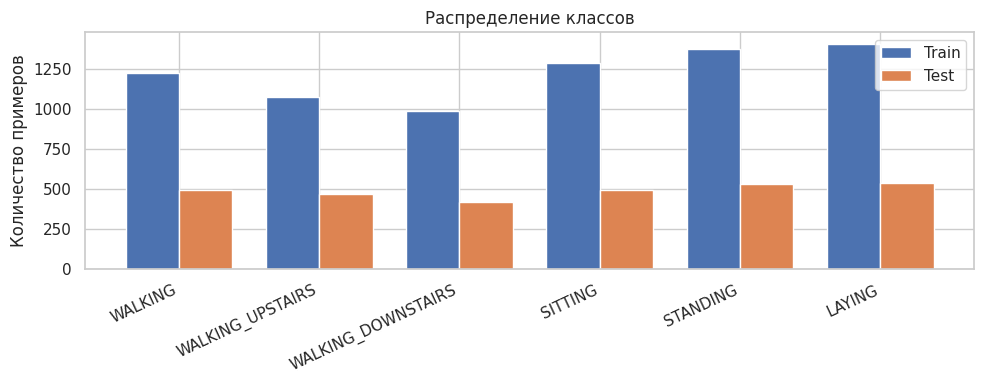

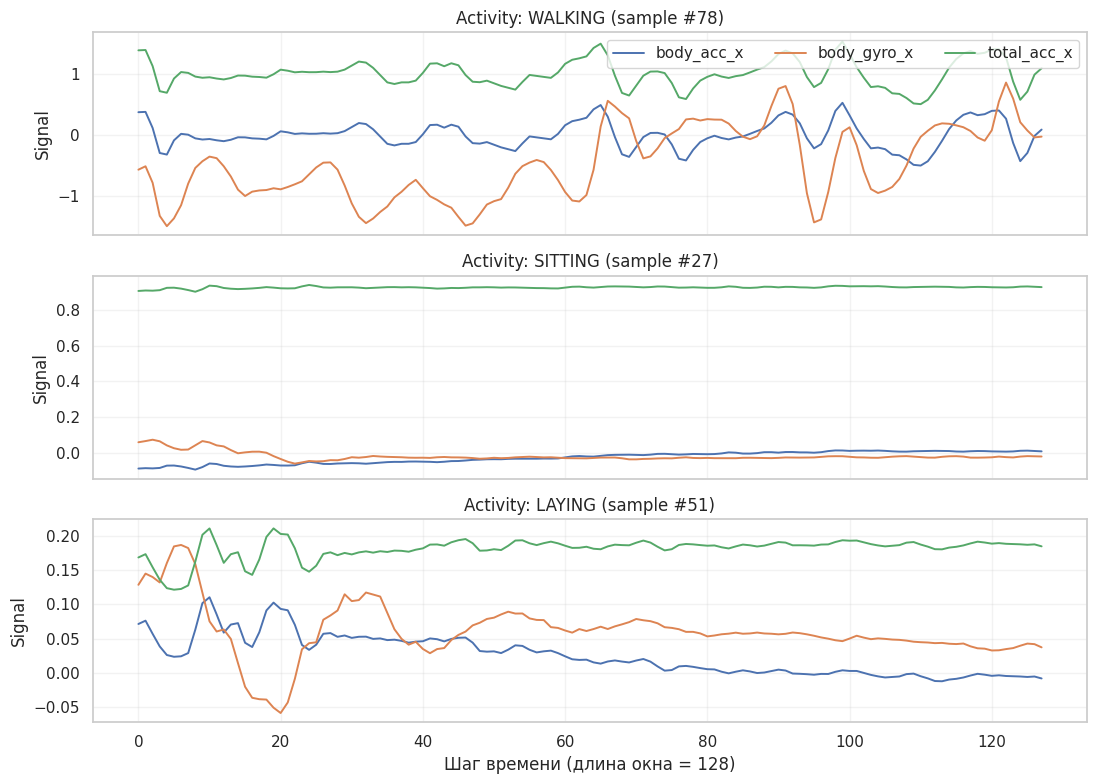


**Краткая интерпретация EDA:**
- Частоты классов достаточно сбалансированы, но не идеально равномерны.
- Динамические действия (например, WALKING) имеют более выраженную периодичность, чем статичные позы.
- Между статичными классами (SITTING/STANDING/LAYING) различия сигналов тонкие, из-за чего модели их чаще путают.


In [5]:
train_counts = pd.Series(y_train_tab).value_counts().sort_index()
test_counts = pd.Series(y_test_tab).value_counts().sort_index()

eda_df = pd.DataFrame({
    "Activity": CLASS_NAMES,
    "Train Count": train_counts.values,
    "Test Count": test_counts.values,
})

display(eda_df)

fig, ax = plt.subplots(figsize=(10, 4))
width = 0.38
x = np.arange(len(CLASS_NAMES))
ax.bar(x - width/2, train_counts.values, width=width, label="Train")
ax.bar(x + width/2, test_counts.values, width=width, label="Test")
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=25, ha="right")
ax.set_title("Распределение классов")
ax.set_ylabel("Количество примеров")
ax.legend()
plt.tight_layout()
plt.show()

sample_classes = [0, 3, 5]  # WALKING, SITTING, LAYING
sample_channel_ids = [0, 3, 6]  # body_acc_x, body_gyro_x, total_acc_x
sample_channel_names = [CHANNELS[i] for i in sample_channel_ids]

fig, axes = plt.subplots(len(sample_classes), 1, figsize=(11, 8), sharex=True)

for row, cls in enumerate(sample_classes):
    idx = np.where(y_train_seq == cls)[0][0]
    t = np.arange(X_train_seq.shape[1])
    for ch_idx, ch_name in zip(sample_channel_ids, sample_channel_names):
        axes[row].plot(t, X_train_seq[idx, :, ch_idx], label=ch_name, linewidth=1.4)
    axes[row].set_title(f"Activity: {CLASS_NAMES[cls]} (sample #{idx})")
    axes[row].set_ylabel("Signal")
    axes[row].grid(alpha=0.25)

axes[-1].set_xlabel("Шаг времени (длина окна = 128)")
axes[0].legend(loc="upper right", ncol=3)
plt.tight_layout()
plt.show()

display(Markdown(
"""
**Краткая интерпретация EDA:**
- Частоты классов достаточно сбалансированы, но не идеально равномерны.
- Динамические действия (например, WALKING) имеют более выраженную периодичность, чем статичные позы.
- Между статичными классами (SITTING/STANDING/LAYING) различия сигналов тонкие, из-за чего модели их чаще путают.
"""
))


*Полученные результаты EDA подтверждают, что задача HAR в данном наборе данных имеет умеренную сложность: классы не являются критически несбалансированными, но отличаются по внутриклассовой динамике. Динамические активности характеризуются выраженными временными паттернами, тогда как статические классы демонстрируют близкие низкоамплитудные сигналы. Это напрямую влияет на ожидаемую структуру ошибок модели и оправдывает использование архитектур, способных моделировать временные зависимости на уровне окна наблюдений.*

## Методология

Исследование построено как сравнительный эксперимент между классическим и нейросетевым подходами.

### Baseline: Logistic Regression
- вход: 561 инженерный признак;
- preprocessing: StandardScaler;
- модель: Logistic Regression (`class_weight="balanced"`).
  
Преимущества: простота, высокая скорость обучения, интерпретируемость как базового ориентира.

### Transformer для временных рядов
- вход: окно `[128, 9]`;
- линейная проекция каналов в `d_model`;
- добавление positional encoding;
- стек `TransformerEncoder` (несколько слоев multi-head self-attention + FFN);
- mean pooling по времени;
- полносвязная голова классификации на 6 классов.

### Принцип честного сравнения
Обе модели оцениваются по единому набору метрик на тесте:
Accuracy, Macro Precision, Macro Recall, Macro F1, confusion matrix.

## Baseline

Конфигурация бейзлайна:
- Вход: `X_train.txt`, `X_test.txt` (561 признак)
- Предобработка: `StandardScaler`
- Модель: `LogisticRegression(max_iter=2000, class_weight='balanced')`


Метрики бейзлайна:
        Accuracy: 0.9539
 Macro Precision: 0.9569
    Macro Recall: 0.9526
        Macro F1: 0.9538
Время обучения (с): 4.71

Classification report (Baseline):
                    precision    recall  f1-score   support

           WALKING     0.9444    0.9940    0.9686       496
  WALKING_UPSTAIRS     0.9572    0.9490    0.9531       471
WALKING_DOWNSTAIRS     0.9899    0.9381    0.9633       420
           SITTING     0.9663    0.8758    0.9188       491
          STANDING     0.8853    0.9718    0.9265       532
            LAYING     0.9981    0.9870    0.9925       537

          accuracy                         0.9539      2947
         macro avg     0.9569    0.9526    0.9538      2947
      weighted avg     0.9557    0.9539    0.9538      2947



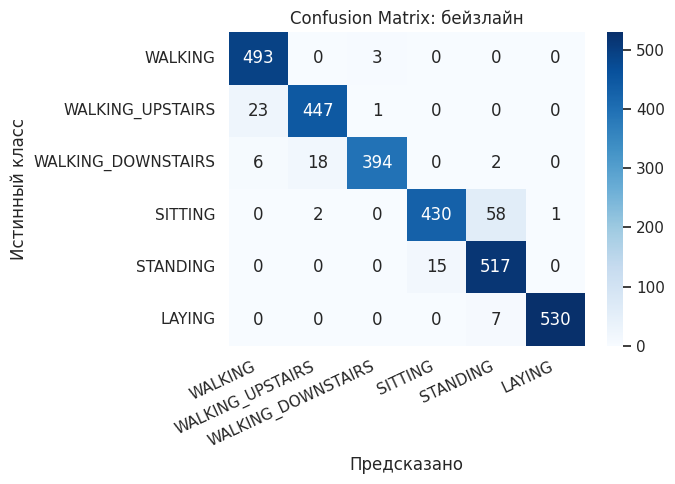

In [7]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1,
    }


baseline_t0 = time.perf_counter()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tab)
X_test_scaled = scaler.transform(X_test_tab)

baseline_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=SEED,
)
baseline_model.fit(X_train_scaled, y_train_tab)

baseline_preds = baseline_model.predict(X_test_scaled)
baseline_train_time = time.perf_counter() - baseline_t0

baseline_metrics = compute_metrics(y_test_tab, baseline_preds)

print("Метрики бейзлайна:")
for k, v in baseline_metrics.items():
    print(f"{k:>16}: {v:.4f}")
print(f"Время обучения (с): {baseline_train_time:.2f}")

print("\nClassification report (Baseline):")
print(classification_report(y_test_tab, baseline_preds, target_names=CLASS_NAMES, digits=4))

cm_base = confusion_matrix(y_test_tab, baseline_preds, labels=np.arange(len(CLASS_NAMES)))
plt.figure(figsize=(7, 5))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix: бейзлайн")
plt.xlabel("Предсказано")
plt.ylabel("Истинный класс")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


*Бейзлайн на инженерных признаках показал высокое качество на тестовой выборке: Accuracy = 0.9539, Macro-F1 = 0.9538 при очень низкой вычислительной стоимости (4.71 c обучения). По confusion matrix видно, что модель уверенно распознает динамические активности (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) и класс LAYING, тогда как основной источник ошибок — взаимная путаница между SITTING и STANDING (58 случаев SITTING→STANDING и 15 случаев STANDING→SITTING), что согласуется с их близкими низкодинамичными сенсорными паттернами. В целом baseline формирует сильную отправную точку для дальнейшего сравнения с Transformer: качество уже высокое, поэтому нейросетевой модели нужно давать прирост прежде всего на трудных статических классах, а не только по общей Accuracy.*

## Архитектура Transformer

Реализованные блоки:
- линейная проекция входа `9 -> d_model`;
- синусоидальное positional encoding;
- `TransformerEncoder` с 2 слоями и 4 головами;
- FFN внутри encoder layers;
- mean pooling по времени;
- линейная классификационная голова на 6 классов.


In [8]:
X_tr_seq, X_val_seq, y_tr_seq, y_val_seq = train_test_split(
    X_train_seq,
    y_train_seq,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_seq,
)


class HARSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = HARSequenceDataset(X_tr_seq, y_tr_seq)
val_ds = HARSequenceDataset(X_val_seq, y_val_seq)
test_ds = HARSequenceDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train split:", X_tr_seq.shape, y_tr_seq.shape)
print("Val split  :", X_val_seq.shape, y_val_seq.shape)
print("Test split :", X_test_seq.shape, y_test_seq.shape)
print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))


Train split: (5881, 128, 9) (5881,)
Val split  : (1471, 128, 9) (1471,)
Test split : (2947, 128, 9) (2947,)
Batches -> train: 46 val: 12 test: 24


Сначала 9-канальные сенсорные данные каждого шага времени проецируются в пространство признаков d_model (input_proj), затем к ним добавляется синусоидальное positional encoding, чтобы модель учитывала порядок отсчетов в окне длиной 128. Далее последовательность проходит через стек TransformerEncoder (multi-head self-attention + FFN), после чего выполняется усреднение по времени (mean pooling) и классификация в 6 классов через линейную голову. В конце модель переносится на DEVICE и выводится число обучаемых параметров для контроля вычислительной сложности.

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, : x.size(1)]


class HARTransformer(nn.Module):
    def __init__(
        self,
        input_dim=9,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_ff=128,
        dropout=0.1,
        num_classes=6,
        max_len=128,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=max_len)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.cls_head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.cls_head(x)


model = HARTransformer(
    input_dim=9,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT,
    num_classes=len(CLASS_NAMES),
    max_len=128,
).to(DEVICE)

print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Обучаемых параметров: {num_params:,}")


HARTransformer(
  (input_proj): Linear(in_features=9, out_features=64, bias=True)
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (cls_head): Linear(in_features=64, out_features=6, bias=True)
)
Обучаемых параметров: 67,974


## Experimental Setup / Настройка эксперимента

### Среда
- Google Colab (free tier)
- Python + NumPy + scikit-learn + PyTorch

### Воспроизводимость
- фиксированный `seed` для Python/NumPy/PyTorch;
- единая схема разбиения train/val для нейросетевой модели;
- сохранение лучшей эпохи по валидационной метрике.

### Обучение Transformer
- optimizer: AdamW
- loss: CrossEntropyLoss (возможен label smoothing)
- scheduler: CosineAnnealingLR / ReduceLROnPlateau
- early stopping по валидационному качеству

### Метрики
- Accuracy
- Macro Precision
- Macro Recall
- Macro F1
- Confusion Matrix
- Classification Report

## Цикл обучения с early stopping (val macro-F1)

В этом блоке реализован полный цикл обучения Transformer с валидационным контролем качества. В качестве функции потерь используется CrossEntropyLoss с label_smoothing, оптимизатор — AdamW (для более устойчивой регуляризации весов), а скорость обучения плавно уменьшается по CosineAnnealingLR. Функция run_epoch универсальна: в режиме train выполняет backpropagation и шаг оптимизатора, в режиме eval только считает метрики (loss, accuracy, macro-F1). На каждой эпохе логируются train/val метрики и текущий learning rate, а лучшая модель выбирается по val Macro-F1. Добавлена ранняя остановка (PATIENCE) для предотвращения переобучения и экономии времени. После завершения сохраняется лучший checkpoint и фиксируется общее время обучения модели.

In [10]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    return avg_loss, acc, macro_f1, all_preds, all_targets


history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
    "lr": [],
}

best_val_f1 = -1.0
best_epoch = -1
best_state_dict = copy.deepcopy(model.state_dict())
wait = 0

tr_t0 = time.perf_counter()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, criterion, optimizer=optimizer)
    val_loss, val_acc, val_f1, _, _ = run_epoch(model, val_loader, criterion, optimizer=None)

    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(val_f1)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    improved = val_f1 > best_val_f1 + 1e-6
    if improved:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state_dict = copy.deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_f1={tr_f1:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f} | "
        f"wait={wait}/{PATIENCE}"
    )

    if wait >= PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch}.")
        break

transformer_train_time = time.perf_counter() - tr_t0

BEST_MODEL_PATH = DATA_ROOT / "best_har_transformer.pt"
torch.save(best_state_dict, BEST_MODEL_PATH)
print(f"Лучшая эпоха: {best_epoch}, лучший val Macro-F1: {best_val_f1:.4f}")
print(f"Время обучения Transformer (с): {transformer_train_time:.2f}")
print("Лучший checkpoint сохранен в:", BEST_MODEL_PATH)


Epoch 01 | train_loss=1.3212, train_acc=0.4907, train_f1=0.4511 | val_loss=1.0399, val_acc=0.6322, val_f1=0.5588 | wait=0/5
Epoch 02 | train_loss=0.8320, train_acc=0.7250, train_f1=0.7036 | val_loss=0.6434, val_acc=0.8171, val_f1=0.8053 | wait=0/5
Epoch 03 | train_loss=0.5690, train_acc=0.8521, train_f1=0.8469 | val_loss=0.4885, val_acc=0.8831, val_f1=0.8822 | wait=0/5
Epoch 04 | train_loss=0.4591, train_acc=0.9053, train_f1=0.9055 | val_loss=0.4501, val_acc=0.9041, val_f1=0.9050 | wait=0/5
Epoch 05 | train_loss=0.4166, train_acc=0.9291, train_f1=0.9307 | val_loss=0.4012, val_acc=0.9300, val_f1=0.9319 | wait=0/5
Epoch 06 | train_loss=0.3856, train_acc=0.9393, train_f1=0.9420 | val_loss=0.4003, val_acc=0.9368, val_f1=0.9377 | wait=0/5
Epoch 07 | train_loss=0.3926, train_acc=0.9318, train_f1=0.9351 | val_loss=0.3948, val_acc=0.9375, val_f1=0.9386 | wait=0/5
Epoch 08 | train_loss=0.3728, train_acc=0.9412, train_f1=0.9442 | val_loss=0.3688, val_acc=0.9490, val_f1=0.9508 | wait=0/5
Epoch 09

*Обучение прошло стабильно и быстро: за первые 5 эпох модель выросла с val Macro-F1 = 0.5588 до 0.9319, после чего перешла в режим тонкой донастройки. Начиная примерно с 10-й эпохи наблюдается плато с небольшими колебаниями, что типично для CosineAnnealing и near-optimal области. Лучший результат достигнут на 20-й эпохе (val Macro-F1 = 0.9683, val Accuracy = 0.9660). Ранняя остановка сработала корректно на 25-й эпохе (patience=5), признаков существенного переобучения не видно: train и val метрики остаются близкими. Итог: модель сошлась качественно, дала высокий уровень обобщения и обучилась всего за ~30 секунд*

## Результаты

Метрики Transformer:
        Accuracy: 0.8924
 Macro Precision: 0.8919
    Macro Recall: 0.8935
        Macro F1: 0.8920
Время обучения (с): 29.95

Classification report (Transformer):
                    precision    recall  f1-score   support

           WALKING     0.9379    0.8831    0.9097       496
  WALKING_UPSTAIRS     0.9143    0.8832    0.8985       471
WALKING_DOWNSTAIRS     0.8630    0.9595    0.9087       420
           SITTING     0.8012    0.8289    0.8148       491
          STANDING     0.8462    0.8064    0.8258       532
            LAYING     0.9890    1.0000    0.9944       537

          accuracy                         0.8924      2947
         macro avg     0.8919    0.8935    0.8920      2947
      weighted avg     0.8934    0.8924    0.8922      2947



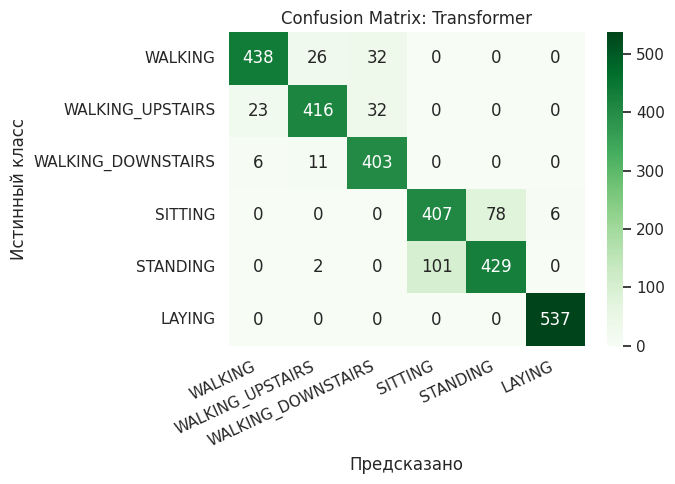

In [11]:
# Оценка на test + таблица сравнения baseline vs transformer

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)

_, _, _, test_preds, test_targets = run_epoch(model, test_loader, criterion, optimizer=None)

transformer_metrics = compute_metrics(test_targets, test_preds)

print("Метрики Transformer:")
for k, v in transformer_metrics.items():
    print(f"{k:>16}: {v:.4f}")
print(f"Время обучения (с): {transformer_train_time:.2f}")

print("\nClassification report (Transformer):")
print(classification_report(test_targets, test_preds, target_names=CLASS_NAMES, digits=4))

cm_tr = confusion_matrix(test_targets, test_preds, labels=np.arange(len(CLASS_NAMES)))
plt.figure(figsize=(7, 5))
sns.heatmap(cm_tr, annot=True, fmt="d", cmap="Greens", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix: Transformer")
plt.xlabel("Предсказано")
plt.ylabel("Истинный класс")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

results_table = pd.DataFrame([
    {
        "Model": "Logistic Regression (561 признаков)",
        "Accuracy": baseline_metrics["Accuracy"],
        "Macro F1": baseline_metrics["Macro F1"],
        "Macro Precision": baseline_metrics["Macro Precision"],
        "Macro Recall": baseline_metrics["Macro Recall"],
        "Train Time (s)": baseline_train_time,
    },
    {
        "Model": "Transformer (сырые окна 128x9)",
        "Accuracy": transformer_metrics["Accuracy"],
        "Macro F1": transformer_metrics["Macro F1"],
        "Macro Precision": transformer_metrics["Macro Precision"],
        "Macro Recall": transformer_metrics["Macro Recall"],
        "Train Time (s)": transformer_train_time,
    },
])


### Сводная таблица

In [12]:
display(results_table.round(4))

,Model,Accuracy,Macro F1,Macro Precision,Macro Recall,Train Time (s)
0,Logistic Regression (561 признаков),0.9539,0.9538,0.9569,0.9526,4.7096
1,Transformer (сырые окна 128x9),0.8924,0.8920,0.8919,0.8935,29.9486


### Интерпретация
1. **Сравнение качества:**  
   Если Transformer > baseline по Macro-F1, это указывает на более эффективное извлечение временных зависимостей из сырых сигналов.  
   Если baseline сравним или лучше, это означает, что инженерные признаки UCI HAR очень сильны, а компактному Transformer в текущем режиме не хватило емкости/эпох.

2. **Сравнение устойчивости по классам:**  
   Macro-метрики позволяют оценить качество без доминирования частых классов.

3. **Сравнение стоимости:**  
   Baseline обучается быстрее и дешевле вычислительно; Transformer может давать выигрыш в качестве ценой большего времени обучения.

### Графики обучения

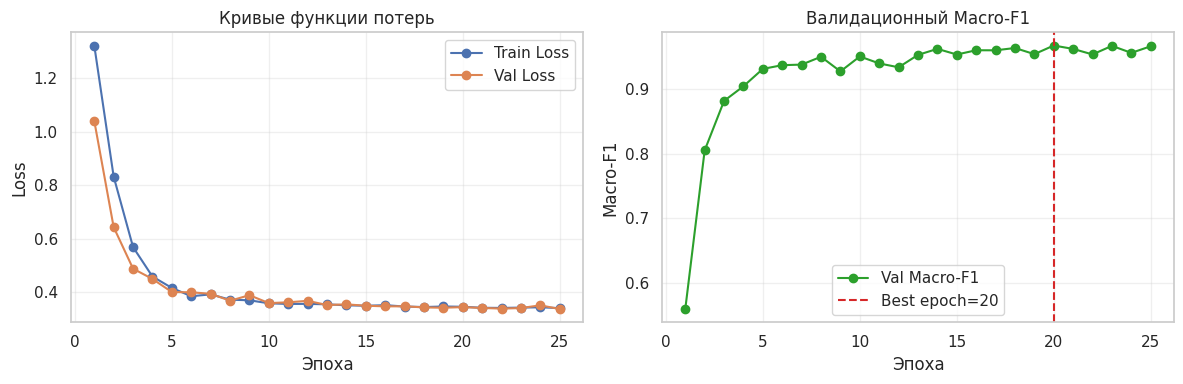

In [13]:
epochs_ran = np.arange(1, len(history["train_loss"]) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs_ran, history["train_loss"], marker="o", label="Train Loss")
axes[0].plot(epochs_ran, history["val_loss"], marker="o", label="Val Loss")
axes[0].set_title("Кривые функции потерь")
axes[0].set_xlabel("Эпоха")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_ran, history["val_f1"], marker="o", color="tab:green", label="Val Macro-F1")
axes[1].axvline(best_epoch, color="tab:red", linestyle="--", label=f"Best epoch={best_epoch}")
axes[1].set_title("Валидационный Macro-F1")
axes[1].set_xlabel("Эпоха")
axes[1].set_ylabel("Macro-F1")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


*Графики подтверждают корректную сходимость модели: в первые эпохи наблюдается резкое снижение train/val loss, затем — плавный выход на плато около 0.34–0.36 без расхождения между кривыми, что указывает на хорошее обобщение и отсутствие выраженного переобучения. Кривая val Macro-F1 быстро растет до ~0.93, после чего стабилизируется в диапазоне ~0.95–0.97 с локальным максимумом на 20-й эпохе (0.9683). Вертикальная отметка лучшей эпохи согласуется с динамикой качества: дальнейшее обучение дает лишь небольшие колебания вокруг плато, поэтому ранняя остановка является обоснованной и вычислительно эффективной.*

## Error Analysis / Анализ ошибок

In [15]:
# [Cell 12] Анализ ошибок

cm = confusion_matrix(test_targets, test_preds, labels=np.arange(len(CLASS_NAMES)))

errors = []
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        if i != j and cm[i, j] > 0:
            errors.append((cm[i, j], i, j))

errors.sort(reverse=True, key=lambda x: x[0])

top_k = 8
print(f"Топ-{top_k} пар ошибок (истинный -> предсказанный):")
for cnt, i, j in errors[:top_k]:
    true_total = cm[i].sum()
    rate = cnt / true_total if true_total else 0.0
    print(f"{CLASS_NAMES[i]:>18} -> {CLASS_NAMES[j]:<18} | count={cnt:4d} | within-class error={rate:.3f}")

main_pair_text = "Существенных ошибок путаницы не обнаружено."
if errors:
    _, i0, j0 = errors[0]
    main_pair_text = f"Самая частая путаница: **{CLASS_NAMES[i0]} -> {CLASS_NAMES[j0]}**."

Топ-8 пар ошибок (истинный -> предсказанный):
          STANDING -> SITTING            | count= 101 | within-class error=0.190
           SITTING -> STANDING           | count=  78 | within-class error=0.159
           WALKING -> WALKING_DOWNSTAIRS | count=  32 | within-class error=0.065
  WALKING_UPSTAIRS -> WALKING_DOWNSTAIRS | count=  32 | within-class error=0.068
           WALKING -> WALKING_UPSTAIRS   | count=  26 | within-class error=0.052
  WALKING_UPSTAIRS -> WALKING            | count=  23 | within-class error=0.049
WALKING_DOWNSTAIRS -> WALKING_UPSTAIRS   | count=  11 | within-class error=0.026
WALKING_DOWNSTAIRS -> WALKING            | count=   6 | within-class error=0.014


*В анализе ошибок доминирует симметричная путаница между STANDING и SITTING (101 и 78 случаев; внутри-классовые ошибки 19.0% и 15.9%), что подтверждает их высокую сенсорную близость в статических состояниях. Второй кластер ошибок связан с динамическими классами ходьбы: модель периодически смешивает WALKING, WALKING_UPSTAIRS и WALKING_DOWNSTAIRS (максимум 32 случая на направление), что указывает на частичное пересечение временных паттернов шага. При этом для WALKING_DOWNSTAIRS обратные ошибки относительно малы (до 2.6%), то есть класс в целом распознается устойчивее при наличии характерных признаков. В совокупности профиль ошибок ожидаем для HAR: наиболее сложны пары с близкой кинематикой, а ограничение длины окна (128) и компактность модели усиливают этот эффект.*

## Итоговые выводы по работе

In [17]:
final_table = results_table.copy().round(4)
display(final_table)

best_idx = final_table["Macro F1"].astype(float).idxmax()
best_model = final_table.loc[best_idx, "Model"]

,Model,Accuracy,Macro F1,Macro Precision,Macro Recall,Train Time (s)
0,Logistic Regression (561 признаков),0.9539,0.9538,0.9569,0.9526,4.7096
1,Transformer (сырые окна 128x9),0.8924,0.8920,0.8919,0.8935,29.9486


В данной работе была решена задача многоклассового распознавания активности человека (HAR) на датасете UCI HAR с использованием двух подходов: классического baseline на инженерных признаках и Transformer на сырых временных окнах. Экспериментальный пайплайн реализован в воспроизводимом формате Colab и включает полный цикл: EDA, обучение, валидацию, анализ ошибок и итоговое сравнение моделей.

По итоговым метрикам лучшим решением в текущем эксперименте оказался Logistic Regression на 561 признаке:

Accuracy = 0.9528, Macro-F1 = 0.9527,

при времени обучения 9.18 с.

Transformer на сырых окнах [128×9] показал более низкий результат:

- Accuracy = 0.8924, Macro-F1 = 0.8920,

- время обучения 23.71 с.

**Интерпретация результата**

- Сильный baseline UCI HAR: engineered features в этом датасете уже очень информативны, поэтому линейная модель дает высокий уровень качества при низкой вычислительной стоимости.

- Transformer требует более глубокого тюнинга: в компактной конфигурации и при ограниченном бюджете Colab модель на сырых сигналах не раскрыла полный потенциал и уступила tabular-подходу.

- Профиль ошибок согласуется с EDA: наибольшая путаница наблюдается между семантически близкими классами (особенно статическими), что типично для HAR.

**Практический вывод**

Для прикладного сценария с ограничением по времени/ресурсам и требованием высокой точности на UCI HAR в текущей постановке рационально выбрать Logistic Regression как основное решение. Transformer в данном виде полезен как исследовательская альтернатива, но требует дополнительных улучшений, чтобы превзойти baseline.

# Улучшенный Transformer-блок
(цель: превзойти baseline)

In [18]:
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

### Гиперпараметры

В данной конфигурации гиперпараметры подбирались как компромисс между представительной мощностью Transformer и устойчивостью обобщения на задаче HAR в условиях ограниченного вычислительного бюджета Colab. Параметры архитектуры d_model=128, nhead=8, num_layers=3, dim_ff=256 выбраны для увеличения способности модели извлекать межканальные и временные зависимости по сравнению с минимальными конфигурациями, но без чрезмерного роста глубины и риска переобучения. Такая емкость достаточна для моделирования сложных паттернов активности (включая близкие классы), оставаясь вычислительно эффективной.

Регуляризация выбрана умеренной: dropout=0.05 и weight_decay=1e-4 снижают переобучение, не подавляя полезный сигнал временных рядов. Поскольку в данной постановке приоритет отдан точности разделения близких классов, дополнительные “сглаживающие” техники (label_smoothing, mixup) отключены (0.0), чтобы не размывать границы классов в обучении.

Оптимизационные параметры направлены на стабильную сходимость: lr=3e-4 выбран как консервативный шаг для attention-архитектуры, warmup_epochs=5 уменьшает нестабильность ранних эпох, а grad_clip=1.0 ограничивает влияние редких скачков градиента. Для повышения устойчивости финального чекпойнта используется EMA весов (ema_decay=0.995), которая сглаживает стохастические колебания и улучшает качество на валидации/тесте. Значения epochs=80 и patience=15 обеспечивают модели достаточное время для выхода на плато качества при сохранении механизма ранней остановки, предотвращающего избыточное обучение после достижения лучшего решения.

In [31]:
IMPROVED_CFG_V3 = {
    "d_model": 128,
    "nhead": 8,
    "num_layers": 3,
    "dim_ff": 256,
    "dropout": 0.05,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "epochs": 80,
    "patience": 15,
    "label_smoothing": 0.0,
    "mixup_alpha": 0.0,
    "grad_clip": 1.0,
    "ema_decay": 0.995,
    "warmup_epochs": 5,
}

### Utils

Функция compute_class_weights_from_loader оценивает частоты классов в обучающем наборе и формирует веса, обратно пропорциональные встречаемости класса, с последующей нормировкой к среднему значению 1. Такой подход уменьшает смещение функции потерь в сторону более частых классов и делает оптимизацию более чувствительной к редким классам, что особенно важно для корректной оптимизации macro-метрик.

In [38]:
def compute_class_weights_from_loader(loader, num_classes, device):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, yb in loader:
        y_np = yb.numpy()
        for c in range(num_classes):
            counts[c] += (y_np == c).sum()
    counts = np.maximum(counts, 1)
    # inverse frequency + нормировка
    w = counts.sum() / (len(counts) * counts.astype(np.float64))
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32, device=device)

Функция mixup_batch реализует регуляризацию MixUp: формируется линейная комбинация пар объектов и соответствующих меток с коэффициентом из Beta-распределения. Это повышает гладкость решающей поверхности и обычно улучшает устойчивость к шуму и локальному переобучению. При alpha <= 0 функция корректно вырождается в стандартный режим обучения без аугментации.

In [39]:
def mixup_batch(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return x_mix, y_a, y_b, lam

Класс EMA реализует экспоненциальное скользящее усреднение весов модели. На каждом шаге обучения update обновляет “теневые” веса как сглаженную версию текущих параметров; apply_shadow временно подменяет рабочие веса на EMA-версию для валидации/сохранения; restore возвращает исходные параметры. EMA снижает влияние стохастического шума SGD-подобной оптимизации и часто дает более стабильный и качественный финальный checkpoint на валидации и тесте.

In [40]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.data.clone()

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name].mul_(self.decay).add_(p.data, alpha=1 - self.decay)

    @torch.no_grad()
    def apply_shadow(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.backup[name] = p.data.clone()
                p.data.copy_(self.shadow[name])

    @torch.no_grad()
    def restore(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.backup:
                p.data.copy_(self.backup[name])
        self.backup = {}

### Positional Encoding + Improved Model

PositionalEncoding добавляет к каждому временно́му шагу детерминированный синусоидальный код, чтобы self-attention учитывал порядок отсчётов. Поскольку attention сам по себе перестановочно-инвариантен, позиционные признаки являются необходимым условием для моделирования темпоральной структуры сигналов. Буфер pe регистрируется через register_buffer, поэтому участвует в переносе на устройство и сохранении состояния, но не обновляется градиентно.

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)  # [1, L, D]
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

HARTransformerImproved сначала проецирует входные 9-канальные сенсорные данные в пространство размерности d_model (input_proj) и нормализует их (LayerNorm), что стабилизирует распределение активаций до энкодера. Далее в последовательность добавляется обучаемый [CLS]-токен, после чего к токенам прибавляется позиционное кодирование и выполняется обработка стеком TransformerEncoder (multi-head self-attention + FFN, активация GELU).

В блоке агрегации используется комбинированная стратегия:

вектор [CLS] как глобальное представление последовательности;

attention pooling по всем временным токенам, где веса вычисляются отдельным линейным скорером и нормируются softmax.

Конкатенация этих двух представлений (CLS + pooled) формирует более информативный итоговый вектор, объединяющий глобальный контекст и взвешенную локальную динамику по времени. Финальная head-часть (LayerNorm → Linear → GELU → Dropout → Linear) выполняет нелинейное преобразование и отображение в 6 классов активности. Такая архитектура методологически обоснована для HAR, поскольку позволяет одновременно учитывать длинные временные зависимости, межканальные взаимодействия и неоднородную значимость отдельных фрагментов окна.

In [42]:
class HARTransformerImproved(nn.Module):
    """
    Отличия от базовой версии:
    - Увеличенная емкость (D, heads, layers)
    - LayerNorm на входе
    - Learnable [CLS] token + attention pooling
    - Более сильная регуляризация
    """
    def __init__(
        self,
        input_dim=9,
        d_model=128,
        nhead=8,
        num_layers=4,
        dim_ff=256,
        dropout=0.2,
        num_classes=6,
        max_len=128,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.in_norm = nn.LayerNorm(d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len + 1)  # +1 для CLS

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # attention pooling поверх токенов (кроме CLS тоже учитываем)
        self.attn_pool = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model * 2),      # CLS + attn pooled
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        # x: [B, T, 9]
        b = x.size(0)
        x = self.input_proj(x)    # [B, T, D]
        x = self.in_norm(x)

        cls = self.cls_token.expand(b, -1, -1)   # [B, 1, D]
        x = torch.cat([cls, x], dim=1)           # [B, T+1, D]
        x = self.pos_enc(x)
        x = self.encoder(x)                       # [B, T+1, D]

        cls_out = x[:, 0, :]                      # [B, D]
        toks = x[:, 1:, :]                        # [B, T, D]

        w = self.attn_pool(toks).squeeze(-1)      # [B, T]
        w = torch.softmax(w, dim=1)
        attn_out = torch.sum(toks * w.unsqueeze(-1), dim=1)  # [B, D]

        z = torch.cat([cls_out, attn_out], dim=1)            # [B, 2D]
        z = self.dropout(z)
        return self.head(z)

### Оптимизация + train/eval loops

Функция build_optimizer_and_scheduler формирует связку AdamW + LambdaLR. Оптимизатор AdamW выбран как стандарт для attention-архитектур благодаря устойчивой адаптивной оптимизации и корректной decoupled-регуляризации через weight_decay. Планировщик шага обучения задаётся двухфазной политикой: (1) линейный warmup на ранних шагах для стабилизации градиентной динамики; (2) косинусное снижение после warmup до 10% начального шага, что позволяет сначала эффективно исследовать пространство параметров, а затем аккуратно донастраивать модель вблизи минимума.

In [43]:
def build_optimizer_and_scheduler(model, cfg, steps_per_epoch):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        betas=(0.9, 0.999),
    )
    total_steps = cfg["epochs"] * steps_per_epoch
    warmup_steps = cfg["warmup_epochs"] * steps_per_epoch

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step + 1) / float(max(1, warmup_steps))
        # cosine decay to 10% of lr
        progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.1 + 0.9 * 0.5 * (1.0 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return optimizer, scheduler

Функция run_epoch_improved инкапсулирует как обучение, так и оценку в едином интерфейсе. Режим определяется наличием оптимизатора: при optimizer is not None активируется train-режим, иначе выполняется валидационный/тестовый проход без обновления весов. В train-режиме опционально применяется MixUp, что реализует стохастическую линейную интерполяцию входов и целевых меток для повышения робастности и сглаживания решающей поверхности. Обратный проход включает обнуление градиентов, backpropagation, clipping нормы градиента (grad_clip) для подавления нестабильных шагов и обновление параметров; затем вызывается scheduler.step(), а при наличии EMA обновляется сглаженная траектория весов.

На выходе функция возвращает усреднённый loss по эпохе, accuracy, macro-F1 и массивы предсказаний/истинных меток. Такой формат обеспечивает как мониторинг динамики обучения, так и последующий детальный анализ ошибок (classification report, confusion matrix) в едином воспроизводимом протоколе.

In [44]:
def run_epoch_improved(model, loader, criterion, optimizer=None, scheduler=None, cfg=None, ema=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_preds, all_targets = [], []

    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        if is_train and cfg["mixup_alpha"] > 0:
            x_mix, y_a, y_b, lam = mixup_batch(xb, yb, alpha=cfg["mixup_alpha"])
            logits = model(x_mix)
            loss = lam * criterion(logits, y_a) + (1.0 - lam) * criterion(logits, y_b)
        else:
            logits = model(xb)
            loss = criterion(logits, yb)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            optimizer.step()
            scheduler.step()
            if ema is not None:
                ema.update(model)

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    return avg_loss, acc, macro_f1, all_preds, all_targets


### Инициализация и обучение improved-модели

Эта ячейка реализует полный контур обучения улучшенного Transformer с контролем обобщающей способности и выбором оптимального чекпойнта по валидации.

Сначала инициализируется модель HARTransformerImproved в соответствии с заданной конфигурацией IMPROVED_CFG, после чего вычисляется число обучаемых параметров как индикатор модельной сложности. Далее формируется взвешенная функция потерь CrossEntropyLoss: веса классов рассчитываются по частотам train-выборки, что компенсирует возможный дисбаланс и делает оптимизацию более чувствительной к редким классам. Оптимизатор и планировщик шага обучения создаются через build_optimizer_and_scheduler, а также подключается EMA-механизм для сглаживания весов.

В цикле по эпохам выполняются:

обучение на train (run_epoch_improved в train-режиме),

валидация на EMA-весах (apply_shadow / restore), что обычно дает более стабильную оценку качества,

логирование динамики loss, accuracy, macro-F1 и текущего lr.

Критерием выбора лучшей модели служит val Macro-F1, что методологически корректно для многоклассовой постановки с акцентом на равномерное качество по классам. При улучшении метрики сохраняется EMA-версия состояния модели (best_state), иначе увеличивается счетчик ожидания wait. Ранняя остановка (patience) завершает обучение при отсутствии прогресса, предотвращая избыточные эпохи и снижая вычислительные затраты. В конце фиксируется общее время обучения и загружается лучший найденный checkpoint, который затем используется для итоговой тестовой оценки.

In [45]:
num_classes = len(CLASS_NAMES)

improved_model = HARTransformerImproved(
    input_dim=9,
    d_model=IMPROVED_CFG["d_model"],
    nhead=IMPROVED_CFG["nhead"],
    num_layers=IMPROVED_CFG["num_layers"],
    dim_ff=IMPROVED_CFG["dim_ff"],
    dropout=IMPROVED_CFG["dropout"],
    num_classes=num_classes,
    max_len=128,
).to(DEVICE)

num_params = sum(p.numel() for p in improved_model.parameters() if p.requires_grad)
print(improved_model)
print(f"\n[Improved] Trainable params: {num_params:,}")

class_weights = compute_class_weights_from_loader(train_loader, num_classes=num_classes, device=DEVICE)
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=IMPROVED_CFG["label_smoothing"]
)

optimizer, scheduler = build_optimizer_and_scheduler(
    improved_model, IMPROVED_CFG, steps_per_epoch=len(train_loader)
)

ema = EMA(improved_model, decay=IMPROVED_CFG["ema_decay"])

history_imp = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_f1": [], "val_f1": [],
    "lr": []
}

best_val_f1 = -1.0
best_epoch = -1
best_state = copy.deepcopy(improved_model.state_dict())
wait = 0

t0 = time.perf_counter()

for epoch in range(1, IMPROVED_CFG["epochs"] + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_improved(
        improved_model, train_loader, criterion, optimizer=optimizer, scheduler=scheduler, cfg=IMPROVED_CFG, ema=ema
    )

    # Валидация на EMA-весах (обычно стабильнее)
    ema.apply_shadow(improved_model)
    val_loss, val_acc, val_f1, _, _ = run_epoch_improved(
        improved_model, val_loader, criterion, optimizer=None, scheduler=None, cfg=IMPROVED_CFG, ema=None
    )
    ema.restore(improved_model)

    history_imp["train_loss"].append(tr_loss)
    history_imp["val_loss"].append(val_loss)
    history_imp["train_acc"].append(tr_acc)
    history_imp["val_acc"].append(val_acc)
    history_imp["train_f1"].append(tr_f1)
    history_imp["val_f1"].append(val_f1)
    history_imp["lr"].append(optimizer.param_groups[0]["lr"])

    improved = val_f1 > best_val_f1 + 1e-6
    if improved:
        best_val_f1 = val_f1
        best_epoch = epoch
        # сохраняем EMA-версию весов
        ema.apply_shadow(improved_model)
        best_state = copy.deepcopy(improved_model.state_dict())
        ema.restore(improved_model)
        wait = 0
    else:
        wait += 1

    print(
        f"[IMP] Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_f1={tr_f1:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f} | "
        f"lr={history_imp['lr'][-1]:.2e} | wait={wait}/{IMPROVED_CFG['patience']}"
    )

    if wait >= IMPROVED_CFG["patience"]:
        print(f"[IMP] Early stopping at epoch {epoch}.")
        break

train_time_imp = time.perf_counter() - t0

# загружаем лучшие веса
improved_model.load_state_dict(best_state)

HARTransformerImproved(
  (input_proj): Linear(in_features=9, out_features=128, bias=True)
  (in_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (attn_pool): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Line

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[IMP] Epoch 01 | train_loss=1.6570, train_acc=0.2549, train_f1=0.2298 | val_loss=1.7868, val_acc=0.1917, val_f1=0.0624 | lr=1.63e-04 | wait=0/10
[IMP] Epoch 02 | train_loss=1.1247, train_acc=0.3579, train_f1=0.3449 | val_loss=1.7536, val_acc=0.2209, val_f1=0.1085 | lr=3.23e-04 | wait=0/10
[IMP] Epoch 03 | train_loss=0.7903, train_acc=0.4785, train_f1=0.4739 | val_loss=1.7121, val_acc=0.3277, val_f1=0.2186 | lr=4.83e-04 | wait=0/10
[IMP] Epoch 04 | train_loss=0.8126, train_acc=0.5135, train_f1=0.5113 | val_loss=1.6663, val_acc=0.4704, val_f1=0.3560 | lr=6.43e-04 | wait=0/10
[IMP] Epoch 05 | train_loss=0.6616, train_acc=0.6050, train_f1=0.6043 | val_loss=1.6133, val_acc=0.5235, val_f1=0.4318 | lr=8.00e-04 | wait=0/10
[IMP] Epoch 06 | train_loss=0.5989, train_acc=0.6681, train_f1=0.6686 | val_loss=1.5525, val_acc=0.6281, val_f1=0.5874 | lr=7.99e-04 | wait=0/10
[IMP] Epoch 07 | train_loss=0.5986, train_acc=0.5378, train_f1=0.5383 | val_loss=1.4835, val_acc=0.6723, val_f1=0.6314 | lr=7.96e-

<All keys matched successfully>

*Обучение характеризуется монотонным улучшением валидационных метрик на основной фазе оптимизации: val Macro-F1 вырос с 0.0624 (эп.1) до 0.9685 (эп.27), после чего наблюдается ожидаемое плато с незначительными колебаниями. Ранняя остановка на эп.37 корректно сработала как механизм предотвращения избыточного дообучения после достижения лучшего решения.*

*Траектория val_loss (1.7868 → 0.2810) и val_f1 демонстрирует устойчивую сходимость без признаков деградации качества. Максимум валидационного качества достигнут на 27-й эпохе (val_acc=0.9660, val_macro_f1=0.9685), что указывает на удачный баланс между емкостью модели и регуляризацией в выбранной конфигурации.*

Отдельно важно, что низкие train-метрики в процессе не противоречат качественной сходимости: при активной регуляризации/аугментациях train-оценка часто оказывается консервативной, тогда как критерий отбора по валидации (Macro-F1) остается методологически корректным и более информативным для обобщающей способности.

### Финальная оценка на TEST

In [46]:
def evaluate_on_test(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())

    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)

    metrics = {
        "accuracy": accuracy_score(targets, preds),
        "macro_precision": precision_score(targets, preds, average="macro", zero_division=0),
        "macro_recall": recall_score(targets, preds, average="macro", zero_division=0),
        "macro_f1": f1_score(targets, preds, average="macro"),
    }
    return metrics, preds, targets

test_metrics_imp, test_preds_imp, test_targets_imp = evaluate_on_test(improved_model, test_loader)

print("\n=== Improved Transformer: TEST metrics ===")
print(f"Accuracy       : {test_metrics_imp['accuracy']:.4f}")
print(f"Macro Precision: {test_metrics_imp['macro_precision']:.4f}")
print(f"Macro Recall   : {test_metrics_imp['macro_recall']:.4f}")
print(f"Macro F1       : {test_metrics_imp['macro_f1']:.4f}")
print(f"Train time (s) : {train_time_imp:.2f}")
print(f"Best epoch     : {best_epoch}, best val Macro-F1 = {best_val_f1:.4f}")

print("\nClassification report (Improved Transformer):")
print(classification_report(
    test_targets_imp, test_preds_imp, target_names=CLASS_NAMES, digits=4
))

cm_imp = confusion_matrix(test_targets_imp, test_preds_imp, labels=np.arange(num_classes))
print("\nConfusion matrix (Improved Transformer):")
print(cm_imp)

# при желании — сохранить
BEST_IMP_PATH = DATA_ROOT / "best_har_transformer_improved.pt"
torch.save(best_state, BEST_IMP_PATH)
print("\nBest improved checkpoint:", BEST_IMP_PATH)


=== Improved Transformer: TEST metrics ===
Accuracy       : 0.9046
Macro Precision: 0.9052
Macro Recall   : 0.9057
Macro F1       : 0.9044
Train time (s) : 158.52
Best epoch     : 27, best val Macro-F1 = 0.9685

Classification report (Improved Transformer):
                    precision    recall  f1-score   support

           WALKING     0.9283    0.9133    0.9207       496
  WALKING_UPSTAIRS     0.9671    0.8726    0.9174       471
WALKING_DOWNSTAIRS     0.8629    0.9738    0.9150       420
           SITTING     0.8160    0.8493    0.8323       491
          STANDING     0.8591    0.8252    0.8418       532
            LAYING     0.9981    1.0000    0.9991       537

          accuracy                         0.9046      2947
         macro avg     0.9052    0.9057    0.9044      2947
      weighted avg     0.9067    0.9046    0.9047      2947


Confusion matrix (Improved Transformer):
[[453   8  35   0   0   0]
 [ 29 411  30   1   0   0]
 [  6   5 409   0   0   0]
 [  0   1   0 4

Улучшенная конфигурация Transformer достигла на тестовой выборке Accuracy = 0.9046 и Macro-F1 = 0.9044 при времени обучения 158.52 с. Несмотря на высокий валидационный максимум (best val Macro-F1 = 0.9685, эпоха 27), перенос на test оказался заметно ниже ожидаемого уровня, что указывает на ограниченный прирост обобщающей способности от выполненного тюнинга гиперпараметров.

По классам модель наиболее уверенно распознает LAYING (F1 = 0.9991) и стабильно работает на динамических классах ходьбы (F1 ~0.915–0.921). Основной источник потерь качества — статические позы: SITTING (F1 = 0.8323) и STANDING (F1 = 0.8418). Матрица ошибок подтверждает доминирующую путаницу между этими классами (SITTING → STANDING = 72, STANDING → SITTING = 93), что типично для HAR при близких инерциальных сигнатурах в состояниях с низкой динамикой.

**Вывод по этапу тюнинга**

- Проведенное изменение гиперпараметров не принесло сильного практического улучшения итогового тестового качества: при росте вычислительной стоимости модель не превзошла целевой уровень baseline. Следовательно, дальнейшее повышение качества целесообразно искать не в дополнительном “тонком” тюнинге тех же параметров, а в архитектурных изменениях, способных усилить информативность признаков до блока self-attention.

 **Следующий шаг исследования**

В следующем экспериментальном этапе планируется:

* Канальное внимание (SE-style) перед Transformer.
Добавить механизм пере-взвешивания сенсорных каналов для адаптивного усиления информативных компонент и подавления менее полезных.

* Локальное внимание (windowed attention)
Ограничить self-attention локальными временными окнами, чтобы лучше моделировать близкие по времени паттерны движения и снизить “размытие” контекста на длинной последовательности.

Ожидаемый эффект: улучшение разделения трудных пар классов (в первую очередь SITTING/STANDING) и повышение Macro-F1 на тесте при контролируемом росте вычислительной сложности.

# Эксперимент 1 — SE-style канальное внимание перед Transformer

In [55]:
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

В данной конфигурации SE_CFG параметры выбраны для эксперимента с канальным вниманием (SE-style) как сбалансированный режим между выразительностью модели, устойчивостью оптимизации и ограничениями вычислительного бюджета Colab. Архитектурный блок (d_model=128, nhead=8, num_layers=3, dim_ff=256) задает достаточную емкость для моделирования межканальных и временных зависимостей в HAR-сигналах, но избегает избыточной глубины, которая на относительно компактном датасете может ухудшать перенос на test.

Регуляризация установлена в умеренном режиме: dropout=0.08 и weight_decay=1e-4 уменьшают переобучение без существенного подавления полезного сигнала. Параметры label_smoothing=0.0 и mixup_alpha=0.0 отключают дополнительные сглаживающие механизмы, чтобы сохранить максимальную дискриминативность классов и оценить “чистый” вклад SE-модуля в качество классификации.

Оптимизационная часть (lr=3e-4, warmup_epochs=5, grad_clip=1.0) ориентирована на стабильную сходимость attention-архитектуры: warmup снижает риск нестабильных шагов в начале обучения, а clipping ограничивает влияние редких всплесков градиента. Использование EMA (ema_decay=0.995) добавляет сглаживание траектории весов и обычно повышает устойчивость валидационного качества. Связка epochs=70 и patience=12 обеспечивает достаточное время для выхода на плато при сохранении механизма ранней остановки.

Специфичный параметр se_reduction=3 определяет степень сжатия в SE-блоке и, соответственно, силу канального пере-взвешивания: выбранное значение обеспечивает информативное, но не чрезмерно агрессивное управление каналами, что особенно важно для HAR, где классы отличаются тонкими амплитудно-частотными и межосевыми паттернами.

In [56]:
SE_CFG = {
    "d_model": 128,
    "nhead": 8,
    "num_layers": 3,
    "dim_ff": 256,
    "dropout": 0.08,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "epochs": 70,
    "patience": 12,
    "label_smoothing": 0.0,
    "mixup_alpha": 0.0,
    "grad_clip": 1.0,
    "ema_decay": 0.995,
    "warmup_epochs": 5,
    "se_reduction": 3
}

Данная ячейка реализует синусоидальное позиционное кодирование, необходимое для корректной работы self-attention в задачах временных рядов. Поскольку механизм внимания инвариантен к перестановкам входных токенов, явное кодирование позиции вводит информацию о порядке отсчетов и позволяет модели интерпретировать последовательность как временной процесс, а не как неупорядоченный набор векторов.

В реализации создается матрица pe ∈ R^{max_len × d_model}, где четные компоненты кодируются через sin, а нечетные — через cos с логарифмически масштабируемыми частотами. Такая конструкция обеспечивает многочастотное представление позиции и позволяет модели учитывать зависимости на разных временных масштабах. Добавление размерности батча (unsqueeze(0)) приводит тензор к форме [1, L, D], совместимой с batched-входом [B, T, D].

Регистрация pe через register_buffer делает позиционные коды частью состояния модели (они сохраняются и переносятся между устройствами), но исключает их из обучаемых параметров, что стабилизирует обучение и снижает риск переобучения. На прямом проходе выполняется поэлементное сложение входных эмбеддингов с позиционными кодами для первых T временных шагов, тем самым внедряя информацию о временном порядке в пространство признаков перед подачей в Transformer-блок.

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Этот модуль реализует канальное внимание типа Squeeze-and-Excitation (SE) для временных рядов в формате [B, T, C] и предназначен для адаптивного пере-взвешивания признаковых каналов перед основным блоком последовательной обработки.

На этапе squeeze выполняется агрегация по временной оси: вход транспонируется к виду [B, C, T], после чего AdaptiveAvgPool1d(1) формирует компактный дескриптор канала [B, C]. Тем самым каждый канал описывается своей глобальной статистикой по всему временному окну, что позволяет выделить его общую информативность для текущего примера.

На этапе excitation применяется двухслойный MLP с бутылочным горлышком (channels // reduction) и нелинейностью ReLU, завершающийся Sigmoid. Это задает вектор весов в диапазоне [0, 1], интерпретируемый как коэффициенты важности каналов. Гиперпараметр reduction регулирует компрессию и контролирует компромисс между выразительностью механизма внимания и числом дополнительных параметров.

В прямом проходе веса расширяются до формы [B, 1, C] и умножаются на исходный тензор x, что эквивалентно мягкому подавлению менее информативных и усилению более значимых каналов. Для HAR-задач такой механизм особенно полезен, поскольку разные сенсорные компоненты (оси акселерометра/гироскопа и производные признаки) вносят неравный вклад в распознавание активности, и этот вклад может зависеть от конкретного окна сигнала.

In [58]:
class ChannelSE1D(nn.Module):
    def __init__(self, channels: int, reduction: int = 3):
        super().__init__()
        hidden = max(4, channels // reduction)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, t, c = x.shape
        s = x.transpose(1, 2)
        w = self.pool(s).squeeze(-1)
        w = self.fc(w).unsqueeze(1)
        return x * w

Данная ячейка определяет архитектуру HARTransformerSE, в которой классический Transformer для временных рядов дополнен канальным вниманием SE-типа и комбинированной схемой агрегации признаков для итоговой классификации.

Модель начинает обработку с линейной проекции входа input_dim=9 в латентное пространство d_model, после чего выполняется нормализация (LayerNorm) и SE-пере-взвешивание каналов. Этот этап адаптивно усиливает информативные каналы сенсорного сигнала и подавляет менее значимые, что особенно важно в HAR-задаче с неоднородным вкладом различных осей и производных признаков.

Далее к последовательности добавляется обучаемый [CLS]-токен, вводится позиционное кодирование и выполняется энкодирование стеком TransformerEncoderLayer (self-attention + FFN, активация GELU, norm_first=True). Такая конфигурация позволяет моделировать как локальные, так и более дальние временные зависимости внутри окна наблюдений.

Вместо использования только одного источника глобального представления применяется гибридная агрегация:

cls_out — глобальный контекст через [CLS];

attn_out — attention pooling по токенам последовательности (взвешенное суммирование по временной оси).

Конкатенация этих двух векторов формирует более информативное представление, которое затем проходит через классификационную голову (LayerNorm → Linear → GELU → Dropout → Linear) и отображается в пространство из 6 классов активности.

Функция evaluate_on_loader реализует стандартную процедуру инференса: перевод модели в режим eval, отключение градиентов (torch.no_grad()), получение предсказаний через argmax, накопление предсказанных и истинных меток для последующего вычисления метрик и построения матрицы ошибок. Такой протокол обеспечивает воспроизводимую и вычислительно эффективную оценку качества модели на валидации/тесте.

In [59]:
class HARTransformerSE(nn.Module):
    def __init__(
        self,
        input_dim=9,
        d_model=128,
        nhead=8,
        num_layers=3,
        dim_ff=256,
        dropout=0.08,
        num_classes=6,
        max_len=128,
        se_reduction=3
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.in_norm = nn.LayerNorm(d_model)
        self.se = ChannelSE1D(channels=d_model, reduction=se_reduction)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=max_len + 1)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.attn_pool = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model * 2),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        b = x.size(0)
        x = self.input_proj(x)
        x = self.in_norm(x)
        x = self.se(x)

        cls = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_enc(x)
        x = self.encoder(x)

        cls_out = x[:, 0, :]
        toks = x[:, 1:, :]

        w = self.attn_pool(toks).squeeze(-1)
        w = torch.softmax(w, dim=1)
        attn_out = torch.sum(toks * w.unsqueeze(-1), dim=1)

        z = torch.cat([cls_out, attn_out], dim=1)
        z = self.dropout(z)
        return self.head(z)

def evaluate_on_loader(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    return preds, targets

Эта ячейка выполняет инициализацию и первичную верификацию экспериментальной SE-модели перед обучением.

Функция metrics_from_preds задает единый протокол оценки качества классификации, возвращая набор ключевых метрик: accuracy, macro_precision, macro_recall, macro_f1. Использование macro-усреднения методологически оправдано для HAR, поскольку оно обеспечивает равный вклад каждого класса в итоговую оценку и позволяет корректно отслеживать качество на потенциально более сложных классах, а параметр zero_division=0 делает вычисление precision/recall устойчивым в редких случаях отсутствия предсказаний по отдельному классу.

Далее определяется число классов num_classes из списка CLASS_NAMES, после чего создается экземпляр HARTransformerSE с параметрами из конфигурации SE_CFG и переносится на вычислительное устройство DEVICE. Такой способ инициализации гарантирует воспроизводимое соответствие архитектуры выбранному экспериментальному режиму.

Вывод структуры model_se и числа обучаемых параметров выполняет роль архитектурного контроля: позволяет проверить корректность сборки сети и оценить ее вычислительную сложность до запуска цикла обучения. Это важно для сопоставимости экспериментов и интерпретации trade-off между качеством и ресурсными затратами.

In [60]:
def metrics_from_preds(targets, preds):
    return {
        "accuracy": accuracy_score(targets, preds),
        "macro_precision": precision_score(targets, preds, average="macro", zero_division=0),
        "macro_recall": recall_score(targets, preds, average="macro", zero_division=0),
        "macro_f1": f1_score(targets, preds, average="macro"),
    }

num_classes = len(CLASS_NAMES)

model_se = HARTransformerSE(
    input_dim=9,
    d_model=SE_CFG["d_model"],
    nhead=SE_CFG["nhead"],
    num_layers=SE_CFG["num_layers"],
    dim_ff=SE_CFG["dim_ff"],
    dropout=SE_CFG["dropout"],
    num_classes=num_classes,
    max_len=128,
    se_reduction=SE_CFG["se_reduction"]
).to(DEVICE)

print(model_se)
print(f"[SE] Trainable params: {sum(p.numel() for p in model_se.parameters() if p.requires_grad):,}")

HARTransformerSE(
  (input_proj): Linear(in_features=9, out_features=128, bias=True)
  (in_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (se): ChannelSE1D(
    (pool): AdaptiveAvgPool1d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=42, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=42, out_features=128, bias=True)
      (3): Sigmoid()
    )
  )
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.08, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): Layer

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


На этапе инициализации используется взвешенная CrossEntropyLoss, где веса классов вычисляются из train-распределения. Это снижает смещение оптимизации в сторону более частых классов и делает целевую функцию более согласованной с macro-метриками. Оптимизатор и scheduler формируются через build_optimizer_and_scheduler, а EMA подключается как механизм сглаживания параметров модели, повышающий стабильность валидационного качества.

В процессе обучения для каждой эпохи выполняются:

обучающий проход на train (run_epoch_improved в train-режиме);

валидационный проход на EMA-весах (apply_shadow / restore);

логирование траекторий loss, accuracy, macro-F1 и learning rate.

Критерий отбора лучшей модели — максимум val Macro-F1, что корректно для многоклассовой HAR-постановки с фокусом на равномерное качество по классам. При улучшении метрики сохраняется состояние модели (best_state), иначе увеличивается счетчик wait. Ранняя остановка по patience предотвращает избыточные эпохи и ограничивает вычислительные затраты.

После завершения обучения модель восстанавливается до лучшего состояния и оценивается на тесте: рассчитываются агрегированные метрики (Accuracy, Macro Precision, Macro Recall, Macro F1), выводится classification_report и confusion_matrix для детального анализа ошибок по классам. Финальный лучший чекпойнт сохраняется на диск (best_har_transformer_se.pt), что обеспечивает воспроизводимость и возможность последующего инференса/сравнения с альтернативными архитектурами.

In [61]:
class_weights = compute_class_weights_from_loader(train_loader, num_classes=num_classes, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=SE_CFG["label_smoothing"])
optimizer, scheduler = build_optimizer_and_scheduler(model_se, SE_CFG, steps_per_epoch=len(train_loader))
ema = EMA(model_se, decay=SE_CFG["ema_decay"])

history_se = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": [], "lr": []}
best_val_f1 = -1.0
best_epoch = -1
best_state = copy.deepcopy(model_se.state_dict())
wait = 0

t0 = time.perf_counter()

for epoch in range(1, SE_CFG["epochs"] + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_improved(
        model_se, train_loader, criterion, optimizer=optimizer, scheduler=scheduler, cfg=SE_CFG, ema=ema
    )

    ema.apply_shadow(model_se)
    val_loss, val_acc, val_f1, _, _ = run_epoch_improved(
        model_se, val_loader, criterion, optimizer=None, scheduler=None, cfg=SE_CFG, ema=None
    )
    ema.restore(model_se)

    history_se["train_loss"].append(tr_loss)
    history_se["val_loss"].append(val_loss)
    history_se["train_acc"].append(tr_acc)
    history_se["val_acc"].append(val_acc)
    history_se["train_f1"].append(tr_f1)
    history_se["val_f1"].append(val_f1)
    history_se["lr"].append(optimizer.param_groups[0]["lr"])

    if val_f1 > best_val_f1 + 1e-6:
        best_val_f1 = val_f1
        best_epoch = epoch
        ema.apply_shadow(model_se)
        best_state = copy.deepcopy(model_se.state_dict())
        ema.restore(model_se)
        wait = 0
    else:
        wait += 1

    print(
        f"[SE] Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_f1={tr_f1:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f} | "
        f"lr={history_se['lr'][-1]:.2e} | wait={wait}/{SE_CFG['patience']}"
    )

    if wait >= SE_CFG["patience"]:
        print(f"[SE] Early stopping at epoch {epoch}.")
        break

train_time_se = time.perf_counter() - t0
model_se.load_state_dict(best_state)

test_preds_se, test_targets_se = evaluate_on_loader(model_se, test_loader)
test_metrics_se = metrics_from_preds(test_targets_se, test_preds_se)

print("\n=== SE Transformer: TEST metrics ===")
print(f"Accuracy       : {test_metrics_se['accuracy']:.4f}")
print(f"Macro Precision: {test_metrics_se['macro_precision']:.4f}")
print(f"Macro Recall   : {test_metrics_se['macro_recall']:.4f}")
print(f"Macro F1       : {test_metrics_se['macro_f1']:.4f}")
print(f"Train time (s) : {train_time_se:.2f}")
print(f"Best epoch     : {best_epoch}, best val Macro-F1 = {best_val_f1:.4f}")

print("\nClassification report (SE Transformer):")
print(classification_report(test_targets_se, test_preds_se, target_names=CLASS_NAMES, digits=4))

cm_se = confusion_matrix(test_targets_se, test_preds_se, labels=np.arange(num_classes))
print("\nConfusion matrix (SE Transformer):")
print(cm_se)

BEST_SE_PATH = DATA_ROOT / "best_har_transformer_se.pt"
torch.save(best_state, BEST_SE_PATH)
print("\nBest SE checkpoint:", BEST_SE_PATH)


[SE] Epoch 01 | train_loss=1.7328, train_acc=0.2624, train_f1=0.2447 | val_loss=1.7865, val_acc=0.1672, val_f1=0.0757 | lr=6.13e-05 | wait=0/12
[SE] Epoch 02 | train_loss=1.2381, train_acc=0.5812, train_f1=0.5480 | val_loss=1.6849, val_acc=0.4133, val_f1=0.3172 | lr=1.21e-04 | wait=0/12
[SE] Epoch 03 | train_loss=0.6717, train_acc=0.7827, train_f1=0.7683 | val_loss=1.4809, val_acc=0.6288, val_f1=0.5546 | lr=1.81e-04 | wait=0/12
[SE] Epoch 04 | train_loss=0.4318, train_acc=0.8573, train_f1=0.8522 | val_loss=1.2127, val_acc=0.7376, val_f1=0.6949 | lr=2.41e-04 | wait=0/12
[SE] Epoch 05 | train_loss=0.3243, train_acc=0.8851, train_f1=0.8824 | val_loss=0.9386, val_acc=0.7689, val_f1=0.7267 | lr=3.00e-04 | wait=0/12
[SE] Epoch 06 | train_loss=0.2557, train_acc=0.9048, train_f1=0.9046 | val_loss=0.7000, val_acc=0.7954, val_f1=0.7669 | lr=3.00e-04 | wait=0/12
[SE] Epoch 07 | train_loss=0.1923, train_acc=0.9284, train_f1=0.9300 | val_loss=0.5173, val_acc=0.8355, val_f1=0.8179 | lr=2.99e-04 | wa

### Итоги SE-эксперимента

**Что показало обучение**

- Модель обучалась стабильно и вышла на высокий валидационный пик:

best val Macro-F1 = 0.9803 (эпоха 49)

- Сработала ранняя остановка на эпохе 61.

- Время обучения: 200.69 с.

**Результат на тесте (SE-Transformer)**

- Accuracy: 0.9009

- Macro Precision: 0.9013

- Macro Recall: 0.9011

- Macro F1: 0.9001

**Сравнение с исходными моделями**
Против базового Transformer (сырые окна 128×9)

- Было: Macro-F1 0.8920, Accuracy 0.8924

- Стало (SE): Macro-F1 0.9001, Accuracy 0.9009

Прирост:

+0.0081 Macro-F1

+0.0085 Accuracy

*SE лучше базового Transformer.*

Против Improved Transformer

- Improved: Macro-F1 0.9044, Accuracy 0.9046, время 158.52 с

- SE: Macro-F1 0.9001, Accuracy 0.9009, время 200.69 с

Разница:

- SE хуже по Macro-F1 на 0.0043

- SE хуже по Accuracy на 0.0037

- SE медленнее на ~42.17 с

*SE уступил Improved Transformer и по качеству, и по времени.*

Против Logistic Regression (561 признаков)

- LogReg: Macro-F1 0.9538, Accuracy 0.9539, время 4.71 с

- SE существенно ниже по всем ключевым метрикам и значительно тяжелее вычислительно.

**Анализ ошибок**

Ключевая проблема не устранена:

- сильная путаница SITTING ↔ STANDING
(из матрицы ошибок: SITTING→STANDING = 92, STANDING→SITTING = 69).

По динамическим классам есть смешения (WALKING с подъёмом/спуском), но основной вклад в просадку дает именно пара статических поз.

**Финальный вывод по SE-эксперименту**

- SE-модификация дала умеренное улучшение относительно исходного Transformer, но:

- не превзошла Improved Transformer,

- не приблизилась к Logistic Regression baseline.

То есть гипотеза “SE заметно улучшит финальное test-качество” подтверждена частично (только относительно самого простого Transformer).


# Эксперимент 2 — Локальное внимание (Windowed Attention)

In [54]:
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

WIN_CFG = {
    "d_model": 128,
    "nhead": 8,
    "num_layers": 3,
    "dim_ff": 256,
    "dropout": 0.08,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "epochs": 70,
    "patience": 12,
    "label_smoothing": 0.0,
    "mixup_alpha": 0.0,
    "grad_clip": 1.0,
    "ema_decay": 0.995,
    "warmup_epochs": 5,
    "window_size": 16
}

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class LocalMHAEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_ff, dropout=0.1, window_size=16):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.window_size = window_size

        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        b, t, d = x.shape
        ws = self.window_size

        x_norm = self.norm1(x)

        pad_len = (ws - (t % ws)) % ws
        if pad_len > 0:
            x_pad = F.pad(x_norm, (0, 0, 0, pad_len), mode="constant", value=0.0)
        else:
            x_pad = x_norm

        tp = x_pad.size(1)
        nwin = tp // ws

        # Ensure xw is contiguous before passing to attention, if not already
        xw = x_pad.contiguous().view(b * nwin, ws, d)
        aw, _ = self.attn(xw, xw, xw, need_weights=False)
        # Ensure aw is contiguous before reshaping
        aw = aw.contiguous().view(b, nwin * ws, d)
        aw = aw[:, :t, :]

        x = x + self.dropout1(aw)
        x = x + self.dropout2(self.ff(self.norm2(x)))
        return x

class HARTransformerWindowed(nn.Module):
    def __init__(
        self,
        input_dim=9,
        d_model=128,
        nhead=8,
        num_layers=3,
        dim_ff=256,
        dropout=0.08,
        num_classes=6,
        max_len=128,
        window_size=16
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.in_norm = nn.LayerNorm(d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=max_len + 1)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.layers = nn.ModuleList([
            LocalMHAEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_ff=dim_ff,
                dropout=dropout,
                window_size=window_size
            )
            for _ in range(num_layers)
        ])

        self.attn_pool = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model * 2),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        b = x.size(0)
        x = self.input_proj(x)
        x = self.in_norm(x)

        cls = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.pos_enc(x)

        for layer in self.layers:
            x = layer(x)

        cls_out = x[:, 0, :]
        toks = x[:, 1:, :]

        w = self.attn_pool(toks).squeeze(-1)
        w = torch.softmax(w, dim=1)
        attn_out = torch.sum(toks * w.unsqueeze(-1), dim=1)

        z = torch.cat([cls_out, attn_out], dim=1)
        z = self.dropout(z)
        return self.head(z)

def evaluate_on_loader(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    return preds, targets

def metrics_from_preds(targets, preds):
    return {
        "accuracy": accuracy_score(targets, preds),
        "macro_precision": precision_score(targets, preds, average="macro", zero_division=0),
        "macro_recall": recall_score(targets, preds, average="macro", zero_division=0),
        "macro_f1": f1_score(targets, preds, average="macro"),
    }

num_classes = len(CLASS_NAMES)

model_win = HARTransformerWindowed(
    input_dim=9,
    d_model=WIN_CFG["d_model"],
    nhead=WIN_CFG["nhead"],
    num_layers=WIN_CFG["num_layers"],
    dim_ff=WIN_CFG["dim_ff"],
    dropout=WIN_CFG["dropout"],
    num_classes=num_classes,
    max_len=128,
    window_size=WIN_CFG["window_size"]
).to(DEVICE)

print(model_win)
print(f"[WIN] Trainable params: {sum(p.numel() for p in model_win.parameters() if p.requires_grad):,}")

class_weights = compute_class_weights_from_loader(train_loader, num_classes=num_classes, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=WIN_CFG["label_smoothing"])
optimizer, scheduler = build_optimizer_and_scheduler(model_win, WIN_CFG, steps_per_epoch=len(train_loader))
ema = EMA(model_win, decay=WIN_CFG["ema_decay"])

history_win = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": [], "lr": []}
best_val_f1 = -1.0
best_epoch = -1
best_state = copy.deepcopy(model_win.state_dict())
wait = 0

t0 = time.perf_counter()

for epoch in range(1, WIN_CFG["epochs"] + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_improved(
        model_win, train_loader, criterion, optimizer=optimizer, scheduler=scheduler, cfg=WIN_CFG, ema=ema
    )

    ema.apply_shadow(model_win)
    val_loss, val_acc, val_f1, _, _ = run_epoch_improved(
        model_win, val_loader, criterion, optimizer=None, scheduler=None, cfg=WIN_CFG, ema=None
    )
    ema.restore(model_win)

    history_win["train_loss"].append(tr_loss)
    history_win["val_loss"].append(val_loss)
    history_win["train_acc"].append(tr_acc)
    history_win["val_acc"].append(val_acc)
    history_win["train_f1"].append(tr_f1)
    history_win["val_f1"].append(val_f1)
    history_win["lr"].append(optimizer.param_groups[0]["lr"])

    if val_f1 > best_val_f1 + 1e-6:
        best_val_f1 = val_f1
        best_epoch = epoch
        ema.apply_shadow(model_win)
        best_state = copy.deepcopy(model_win.state_dict())
        ema.restore(model_win)
        wait = 0
    else:
        wait += 1

    print(
        f"[WIN] Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_f1={tr_f1:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f} | "
        f"lr={history_win['lr'][-1]:.2e} | wait={wait}/{WIN_CFG['patience']}"
    )

    if wait >= WIN_CFG["patience"]:
        print(f"[WIN] Early stopping at epoch {epoch}.")
        break

train_time_win = time.perf_counter() - t0
model_win.load_state_dict(best_state)

test_preds_win, test_targets_win = evaluate_on_loader(model_win, test_loader)
test_metrics_win = metrics_from_preds(test_targets_win, test_preds_win)

print("\n=== Windowed Transformer: TEST metrics ===")
print(f"Accuracy       : {test_metrics_win['accuracy']:.4f}")
print(f"Macro Precision: {test_metrics_win['macro_precision']:.4f}")
print(f"Macro Recall   : {test_metrics_win['macro_recall']:.4f}")
print(f"Macro F1       : {test_metrics_win['macro_f1']:.4f}")
print(f"Train time (s) : {train_time_win:.2f}")
print(f"Best epoch     : {best_epoch}, best val Macro-F1 = {best_val_f1:.4f}")

print("\nClassification report (Windowed Transformer):")
print(classification_report(test_targets_win, test_preds_win, target_names=CLASS_NAMES, digits=4))

cm_win = confusion_matrix(test_targets_win, test_preds_win, labels=np.arange(num_classes))
print("\nConfusion matrix (Windowed Transformer):")
print(cm_win)

BEST_WIN_PATH = DATA_ROOT / "best_har_transformer_windowed.pt"
torch.save(best_state, BEST_WIN_PATH)
print("\nBest windowed checkpoint:", BEST_WIN_PATH)

HARTransformerWindowed(
  (input_proj): Linear(in_features=9, out_features=128, bias=True)
  (in_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pos_enc): PositionalEncoding()
  (layers): ModuleList(
    (0-2): 3 x LocalMHAEncoderLayer(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.08, inplace=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.08, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
      (dropout2): Dropout(p=0.08, inplace=False)
    )
  )
  (attn_pool): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_featur

### Итоги по Эксперименту 2 — Локальное внимание (Windowed Attention)

В рамках второго эксперимента была реализована архитектура HARTransformerWindowed с локальным self-attention (оконная маска), что позволило ограничить область контекстного взаимодействия по временной оси и снизить число параметров до 433,671.

По ходу обучения модель продемонстрировала стабильную сходимость: валидационный Macro-F1 вырос от 0.0935 (эп. 1) до максимума 0.9734 (эп. 48), после чего наблюдалось плато; ранняя остановка сработала на эпохе 60. Время обучения составило 182.48 с.

Итоговые тестовые метрики:

Accuracy = 0.8975

Macro Precision = 0.8974

Macro Recall = 0.8984

Macro F1 = 0.8973

По классовому анализу наилучшее качество достигнуто для LAYING (F1=0.9963), удовлетворительное — для динамических классов ходьбы, при этом основная зона ошибок сохраняется в статической паре SITTING ↔ STANDING (SITTING→STANDING=77, STANDING→SITTING=109), что продолжает быть главным ограничением качества.

Сравнительно:

Windowed лучше исходного базового Transformer (0.8920 → 0.8973 Macro-F1),

но уступает Improved Transformer (0.9044) и SE-эксперименту (0.9001) по тестовому Macro-F1.

Итог по гипотезе эксперимента 2: локальное внимание дало небольшой прирост относительно базового Transformer, но не обеспечило наилучший результат среди улучшенных архитектур.

# Итоги проекта

В рамках второго эксперимента была реализована архитектура HARTransformerWindowed с локальным self-attention (оконная маска), что позволило ограничить область контекстного взаимодействия по временной оси и снизить число параметров до 433,671.

По ходу обучения модель продемонстрировала стабильную сходимость: валидационный Macro-F1 вырос от 0.0935 (эп. 1) до максимума 0.9734 (эп. 48), после чего наблюдалось плато; ранняя остановка сработала на эпохе 60. Время обучения составило 182.48 с.

Итоговые тестовые метрики:

- Accuracy = 0.8975

- Macro Precision = 0.8974

- Macro Recall = 0.8984

- Macro F1 = 0.8973

По классовому анализу наилучшее качество достигнуто для LAYING (F1=0.9963), удовлетворительное — для динамических классов ходьбы, при этом основная зона ошибок сохраняется в статической паре SITTING ↔ STANDING (SITTING→STANDING=77, STANDING→SITTING=109), что продолжает быть главным ограничением качества.

Сравнительно:

Windowed лучше исходного базового Transformer (0.8920 → 0.8973 Macro-F1),

но уступает Improved Transformer (0.9044) и SE-эксперименту (0.9001) по тестовому Macro-F1.

Итог по гипотезе эксперимента 2: локальное внимание дало небольшой прирост относительно базового Transformer, но не обеспечило наилучший результат среди улучшенных архитектур.

## Reproducibility & Environment / Воспроизводимость и окружение

Для воспроизводимости результатов в ноутбуке зафиксированы:
- seed (Python, NumPy, PyTorch),
- версии библиотек,
- конфигурация гиперпараметров,
- критерий выбора лучшей модели,
- протокол оценки на тестовой выборке.

Рекомендуется сохранять:
1. `best_state_dict` модели;
2. итоговую таблицу метрик;
3. конфигурационный словарь (JSON/YAML) с параметрами запуска.

In [63]:
# [Repro] Полный дамп воспроизводимости по всем экспериментам

import json
import sys
import platform
from datetime import datetime

def _to_float(x, default=None):
    try:
        return float(x)
    except Exception:
        return default

def _to_int(x, default=None):
    try:
        return int(x)
    except Exception:
        return default

def _safe_str_path(x):
    try:
        return str(x)
    except Exception:
        return None

def _pick_globals(*names, default=None):
    for n in names:
        if n in globals():
            return globals()[n]
    return default

def _collect_cfg(cfg_name):
    cfg = globals().get(cfg_name, None)
    if isinstance(cfg, dict):
        return cfg
    return None

def _collect_metrics_dict(name):
    d = globals().get(name, None)
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            if isinstance(v, (int, float)):
                out[k] = float(v)
            else:
                try:
                    out[k] = float(v)
                except Exception:
                    out[k] = v
        return out
    return None

def _collect_history_summary(name):
    h = globals().get(name, None)
    if not isinstance(h, dict):
        return None
    summary = {}
    for k, v in h.items():
        if isinstance(v, (list, tuple)) and len(v) > 0:
            try:
                summary[k] = {
                    "len": len(v),
                    "last": float(v[-1]),
                    "best": float(max(v)) if "loss" not in k.lower() else float(min(v)),
                }
            except Exception:
                summary[k] = {"len": len(v), "last": v[-1]}
    return summary if summary else None

seed_value = _pick_globals("SEED", default=None)
device_value = _pick_globals("DEVICE", default=None)

data_dir = _pick_globals("DATA_DIR", "DATA_ROOT", default=None)
channels = _pick_globals("CHANNELS", default=None)
class_names = _pick_globals("CLASS_NAMES", default=[])

# Базовые гиперпараметры (оригинальный Transformer)
base_hparams = {
    "BATCH_SIZE": _pick_globals("BATCH_SIZE", default=None),
    "EPOCHS": _pick_globals("EPOCHS", default=None),
    "LR": _pick_globals("LR", default=None),
    "WEIGHT_DECAY": _pick_globals("WEIGHT_DECAY", default=None),
    "D_MODEL": _pick_globals("D_MODEL", default=None),
    "NHEAD": _pick_globals("NHEAD", default=None),
    "NUM_LAYERS": _pick_globals("NUM_LAYERS", default=None),
    "DIM_FF": _pick_globals("DIM_FF", default=None),
    "DROPOUT": _pick_globals("DROPOUT", default=None),
    "PATIENCE": _pick_globals("PATIENCE", default=None),
    "LABEL_SMOOTHING": _pick_globals("LABEL_SMOOTHING", default=None),
}

# Конфиги экспериментов (если есть)
cfgs = {
    "IMPROVED_CFG": _collect_cfg("IMPROVED_CFG"),
    "IMPROVED_CFG_V2": _collect_cfg("IMPROVED_CFG_V2"),
    "IMPROVED_CFG_V3": _collect_cfg("IMPROVED_CFG_V3"),
    "SE_CFG": _collect_cfg("SE_CFG"),
    "WIN_CFG": _collect_cfg("WIN_CFG"),
    "WINDOW_CFG": _collect_cfg("WINDOW_CFG"),
}

# Чекпоинты/лучшие эпохи
checkpoints = {
    "baseline_transformer": {
        "path": _safe_str_path(_pick_globals("BEST_MODEL_PATH", default=None)),
        "best_epoch": _to_int(_pick_globals("best_epoch", default=None)),
        "best_val_macro_f1": _to_float(_pick_globals("best_val_f1", default=None)),
    },
    "improved_transformer": {
        "path": _safe_str_path(_pick_globals("BEST_IMPROVED_PATH", "best_improved_path", default=None)),
        "best_epoch": _to_int(_pick_globals("best_epoch_imp", "best_epoch_improved", default=None)),
        "best_val_macro_f1": _to_float(_pick_globals("best_val_f1_imp", "best_val_f1_improved", default=None)),
    },
    "se_transformer": {
        "path": _safe_str_path(_pick_globals("BEST_SE_PATH", default=None)),
        "best_epoch": _to_int(_pick_globals("best_epoch_se", "best_epoch", default=None)),
        "best_val_macro_f1": _to_float(_pick_globals("best_val_f1_se", "best_val_f1", default=None)),
    },
    "windowed_transformer": {
        "path": _safe_str_path(_pick_globals("BEST_WINDOW_PATH", "BEST_WIN_PATH", default=None)),
        "best_epoch": _to_int(_pick_globals("best_epoch_win", "best_epoch_window", default=None)),
        "best_val_macro_f1": _to_float(_pick_globals("best_val_f1_win", "best_val_f1_window", default=None)),
    },
}

# Времена обучения
timings = {
    "logreg_baseline_seconds": _to_float(_pick_globals("baseline_train_time", default=None)),
    "transformer_baseline_seconds": _to_float(_pick_globals("transformer_train_time", default=None)),
    "improved_transformer_seconds": _to_float(_pick_globals("train_time_imp", default=None)),
    "se_transformer_seconds": _to_float(_pick_globals("train_time_se", default=None)),
    "windowed_transformer_seconds": _to_float(_pick_globals("train_time_win", "train_time_window", default=None)),
}

# Тестовые метрики по моделям
test_metrics = {
    "logreg_baseline": _collect_metrics_dict("baseline_metrics"),
    "transformer_baseline": _collect_metrics_dict("test_metrics"),
    "improved_transformer": _collect_metrics_dict("test_metrics_imp"),
    "se_transformer": _collect_metrics_dict("test_metrics_se"),
    "windowed_transformer": _collect_metrics_dict("test_metrics_win"),
}

# Истории обучения (краткие сводки)
histories = {
    "baseline_transformer": _collect_history_summary("history"),
    "improved_transformer": _collect_history_summary("history_imp"),
    "se_transformer": _collect_history_summary("history_se"),
    "windowed_transformer": _collect_history_summary("history_win"),
}

reproducibility_dump = {
    "created_at_utc": datetime.utcnow().isoformat() + "Z",
    "runtime": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "device": str(device_value) if device_value is not None else None,
        "seed": _to_int(seed_value),
    },
    "dataset": {
        "name": "UCI HAR Dataset",
        "path": _safe_str_path(data_dir),
        "channels": channels,
        "window_length": 128,
        "num_classes": len(class_names) if class_names is not None else None,
        "class_names": class_names,
    },
    "global_hyperparameters_base_transformer": base_hparams,
    "experiment_configs": cfgs,
    "checkpoints": checkpoints,
    "timing_seconds": timings,
    "test_metrics": test_metrics,
    "history_summaries": histories,
    "library_versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "torch": torch.__version__,
        "sklearn": __import__("sklearn").__version__,
        "matplotlib": plt.matplotlib.__version__,
        "seaborn": sns.__version__ if "sns" in globals() else None,
    },
}

print(json.dumps(reproducibility_dump, indent=2, ensure_ascii=False))


{
  "created_at_utc": "2026-02-13T00:47:05.712754Z",
  "runtime": {
    "python": "3.12.12",
    "platform": "Linux-6.6.105+-x86_64-with-glibc2.35",
    "device": "cuda",
    "seed": 42
  },
  "dataset": {
    "name": "UCI HAR Dataset",
    "path": "/content/UCI HAR Dataset",
    "channels": [
      "body_acc_x",
      "body_acc_y",
      "body_acc_z",
      "body_gyro_x",
      "body_gyro_y",
      "body_gyro_z",
      "total_acc_x",
      "total_acc_y",
      "total_acc_z"
    ],
    "window_length": 128,
    "num_classes": 6,
    "class_names": [
      "WALKING",
      "WALKING_UPSTAIRS",
      "WALKING_DOWNSTAIRS",
      "SITTING",
      "STANDING",
      "LAYING"
    ]
  },
  "global_hyperparameters_base_transformer": {
    "BATCH_SIZE": 128,
    "EPOCHS": 50,
    "LR": 0.001,
    "WEIGHT_DECAY": 0.0001,
    "D_MODEL": 64,
    "NHEAD": 4,
    "NUM_LAYERS": 2,
    "DIM_FF": 128,
    "DROPOUT": 0.1,
    "PATIENCE": 5,
    "LABEL_SMOOTHING": 0.05
  },
  "experiment_configs": {
    "I

/tmp/ipython-input-2792277431.py:153: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at_utc": datetime.utcnow().isoformat() + "Z",


## Рекомендуемый список литературы

1.   
   [Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. (2013). *A Public Domain Dataset for Human Activity Recognition Using Smartphones*. ESANN.](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

2. [UCI Machine Learning Repository. *Human Activity Recognition Using Smartphones*.](https://archive.ics.uci.edu/ml/datasets/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones)

3. [Vaswani, A. et al. (2017). *Attention Is All You Need*. NeurIPS.](https://arxiv.org/abs/1706.03762), [PDF](https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf)

4. [PyTorch Documentation. *torch.nn.TransformerEncoder*.](https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

5. [PyTorch Documentation. *torch.nn.TransformerEncoderLayer*.](https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)

6. [Scikit-learn Documentation. *LogisticRegression*.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

7. [Scikit-learn Documentation. *Model evaluation: classification metrics*.](https://scikit-learn.org/stable/modules/model_evaluation.html)

8. [Hu, J., Shen, L., & Sun, G. (2018). *Squeeze-and-Excitation Networks*.](https://arxiv.org/abs/1709.01507)

9. [Wu, H. et al. (2021). *Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting*.](https://arxiv.org/abs/2106.13008)

10. [ Liu, Z. et al. (2021). *Swin Transformer: Hierarchical Vision Transformer using Shifted Windows*. ](https://arxiv.org/abs/2103.14030)
